In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

# from data.data_accessors import tmprss2_to_pandas
import numpy as np
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pickle

random.seed(1)

os.chdir('/Users/JacobUmans/tmprss2/notebooks')

In [2]:
# collect dataset
dataset = pd.read_pickle("../dumps/combined_dataset.pkl")
dataset

,acvalue_target,activity_target,target,tmprss2_vs_target_spearman_r,acvalue_scaled_to_tmprss2,cid,morgan_fingerprint
0,0.019,Active,TMPRSS2,1.000000,0.019,46899577,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.019,Active,TMPRSS2,1.000000,0.019,56677005,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.020,Active,TMPRSS2,1.000000,0.020,49835415,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.021,Active,TMPRSS2,1.000000,0.021,49835557,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.044,Active,TMPRSS2,1.000000,0.044,0,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
890,0.168,Active,TMPRSS11D,0.064941,NaN,49835606,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
891,0.038,Active,TMPRSS11D,0.064941,NaN,56680339,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
892,0.043,Active,TMPRSS11D,0.064941,NaN,56683657,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
893,0.183,Active,TMPRSS11D,0.064941,NaN,56683658,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [3]:
fingerprints = dataset.morgan_fingerprint
X = np.zeros([len(dataset), 2048])
for i in range(len(dataset)):
    for j in range(2048):
        X[i][j] = fingerprints[i][j]

y = np.array(dataset.acvalue_scaled_to_tmprss2)

X = X[~np.isnan(y)]

y = -np.log10(y)
y = y[~np.isnan(y)]

In [4]:
#split training and testing data for each dataset
print(y.shape)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

(425,)


SVR RMSE:1.1579656579547117
(0.6063181780564431, 7.772169592014956e-10)


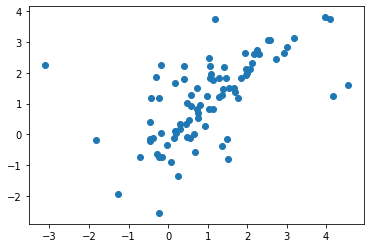

In [5]:
#SVM regression
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

In [6]:
# collect dataset
broad_library = pd.read_csv('../data/broad_repurposing_library.csv')
broad_library = broad_library.drop(9603)
broad_library = broad_library.drop(9602)
broad_library = broad_library.drop(9040)
broad_library = broad_library.drop(8416)
broad_library = broad_library.drop(7224)
broad_library = broad_library.drop(2548)
broad_library['fingerprints'] = broad_library.smiles.apply(lambda s: Chem.RDKFingerprint(Chem.MolFromSmiles(s)))


In [7]:
broad_fingerprints = np.zeros([len(broad_library), 2048])
for i in range(len(broad_library)):
    DataStructs.ConvertToNumpyArray(broad_library.fingerprints.iloc[i], broad_fingerprints[i])

In [8]:
svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
svmReg_full.fit(X, y)
predictions = np.zeros([len(broad_fingerprints), 2])
pred_values = svmReg_full.predict(broad_fingerprints)

In [9]:
argsort = np.argsort(pred_values)
compounds_sorted = broad_library.smiles[argsort]
pred_values_sorted = pred_values[argsort]


[-30.39500154 -30.39500154 -30.39500154 ...  13.06111162  13.06111162
  13.06111162]
8510              COc1ccc(CCCOC(Cn2ccnc2)c2ccc(OC)cc2)cc1
8508                                     CN(C)CCCCSC(N)=N
8509                                     CN(C)CCCCSC(N)=N
8992    CC(=O)Nc1cccc(Nc2ncnc(n2)N2CCC(CC2)OCc2ccc(OC(...
5419        Nc1nc(SCc2ncc[nH]2)c(C#N)c(-c2ccc(O)cc2)c1C#N
                              ...                        
279     CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@@](C)(O)CCC...
280     CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@@](C)(O)CCC...
2545    COC1=C(OC)C(=O)C(C\C=C(/C)CC\C=C(/C)CC\C=C(/C)...
2544    COC1=C(OC)C(=O)C(C\C=C(/C)CC\C=C(/C)CC\C=C(/C)...
2543    COC1=C(OC)C(=O)C(C\C=C(/C)CC\C=C(/C)CC\C=C(/C)...
Name: smiles, Length: 10141, dtype: object


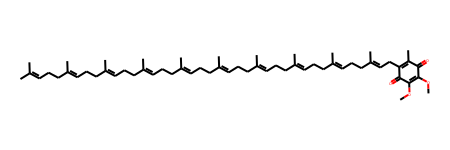

In [10]:
Chem.MolFromSmiles(compounds_sorted[2543])


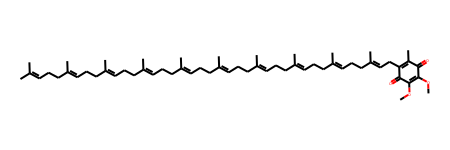

In [11]:
Chem.MolFromSmiles(compounds_sorted[2544])


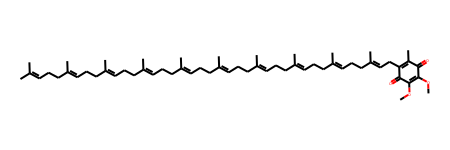

In [12]:
Chem.MolFromSmiles(compounds_sorted[2545])

In [13]:
compounds_sorted[2543]

'COC1=C(OC)C(=O)C(C\\C=C(/C)CC\\C=C(/C)CC\\C=C(/C)CC\\C=C(/C)CC\\C=C(/C)CC\\C=C(/C)CC\\C=C(/C)CC\\C=C(/C)CC\\C=C(/C)CCC=C(C)C)=C(C)C1=O'

In [14]:
broad_library.iloc[280]

broad_id                                      BRD-K57865272-001-01-2
pert_iname                                                     A0001
qc_incompatible                                                    0
purity                                                         40.81
vendor                                                          Enzo
catalog_no                                                     FR115
vendor_name                                        Tocopherylquinone
expected_mass                                                446.376
smiles             CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@@](C)(O)CCC...
InChIKey                                 LTVDFSLWFKLJDQ-IEOSBIPESA-N
pubchem_cid                                              2.73409e+06
fingerprints       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
Name: 280, dtype: object

In [15]:
broad_library.iloc[2543]

broad_id                                      BRD-K75043328-001-05-9
pert_iname                                              coenzyme-q10
qc_incompatible                                                    0
purity                                                             0
vendor                                                         Sigma
catalog_no                                              MFCD00042919
vendor_name        2-[(2E,6E,10E,14E,18E,22E,26E,30E,34E)-3,7,11,...
expected_mass                                                862.684
smiles             COC1=C(OC)C(=O)C(C\C=C(/C)CC\C=C(/C)CC\C=C(/C)...
InChIKey                                 ACTIUHUUMQJHFO-UPTCCGCDSA-N
pubchem_cid                                              5.28192e+06
fingerprints       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...
Name: 2543, dtype: object

Text(0.5, 1.0, 'SVM Validation Data')

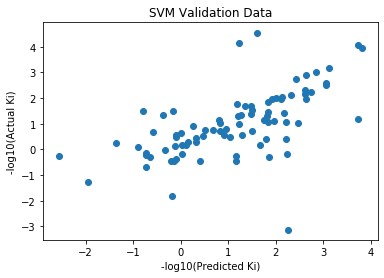

In [17]:
plt.scatter(pred, test_y)
plt.xlabel('-log10(Predicted Ki), nM')
plt.ylabel('-log10(Actual Ki), nM')
plt.title('SVM Validation Data')